In [1]:
import numpy as np
import tensorflow as tf
from load_dataset import load_dataset
import matplotlib.pyplot as plt

In [2]:
x_train,t_train = load_dataset('./train_dataset',convert_type='RGB',flatten=True,normalize=True,one_hot_label=True)
x_test,t_test = load_dataset('./test_dataset',convert_type='RGB',flatten=True,normalize=True,one_hot_label=True)

Load label : Done!
Load img : Done!
Load label : Done!
Load img : Done!


In [3]:
def list_shuffle(datas,labels):
    ###データのシャッフル
    index_list = np.arange(0,datas.shape[0])
    np.random.shuffle(index_list)
    x_data = datas[index_list]
    t_data = labels[index_list]
    return x_data,t_data

In [4]:
x_train_shuffle,t_train_shuffle = list_shuffle(x_train,t_train)
x_test_shuffle,t_test_shuffle = list_shuffle(x_test,t_test)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, 64*64*3],name="input")
t = tf.placeholder(tf.float32, shape=[None, 2])

### 入力層
input_layer = tf.reshape(X, [-1,64,64,3])

### 畳込み層、プーリング層1
h_conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding='same',activation=tf.nn.relu)
h_pool1 = tf.layers.max_pooling2d(inputs=h_conv1,pool_size=(2,2),strides=(2,2),padding='same')

### 畳込み層、プーリング層2
h_conv2 = tf.layers.conv2d(inputs=h_pool1,filters=64,kernel_size=[5, 5],padding='same',activation=tf.nn.relu)
h_pool2 = tf.layers.max_pooling2d(inputs=h_conv2,pool_size=(2,2),strides=(2,2),padding='same')
print(h_conv2)
### 全結合層
stddev = np.sqrt(2.0 / 16*16*64)
h_W_fc1 = tf.Variable(tf.truncated_normal([16*16*64,256], stddev=stddev))
h_b_fc1 = tf.Variable(tf.constant(0.1, shape=[256]))
h_pool2_flat = tf.reshape(h_pool2, [-1, 16*16*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, h_W_fc1) + h_b_fc1)

### ドロップアウト
keep_prob = tf.placeholder(tf.float32) # ドロップアウトする割合
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### 出力層
stddev = np.sqrt(2.0 / 256)
W_fc2 = tf.Variable(tf.truncated_normal([256,2], stddev=stddev))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[2]))
fc = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
y_conv = tf.nn.softmax(fc,name="output")

### 損失
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y_conv))

### 学習op
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)

### モデルの評価
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(t,1))
# 精度
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Tensor("conv2d_2/Relu:0", shape=(?, 32, 32, 64), dtype=float32)


In [6]:
x_train_shuffle.shape[0]

168

In [6]:
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 4

for i in range(5000):
    batch_mask = np.random.choice(x_train_shuffle.shape[0], batch_size)
    x_batch = x_train_shuffle[batch_mask]
    t_batch = t_train_shuffle[batch_mask]
    sess.run(train_step,feed_dict={X: x_batch, t: t_batch,keep_prob:0.5})
    if i % 100 == 0:
        train_acc, train_loss = sess.run([accuracy,loss], feed_dict={X: x_train_shuffle, t: t_train_shuffle,keep_prob:1.0})
        test_acc = sess.run(accuracy, feed_dict={X: x_test_shuffle, t: t_test_shuffle,keep_prob:1.0})
        print "[Train] step: %d, loss: %f, acc: %f, [Test] acc : %f" % (i, train_loss, train_acc,test_acc)
        
saver.save(sess, "./RoadSign-ckpt/roadsign-conv")

[Train] step: 0, loss: 0.633955, acc: 0.523810, [Test] acc : 0.500000
[Train] step: 100, loss: 0.556125, acc: 0.898810, [Test] acc : 0.727273
[Train] step: 200, loss: 0.719719, acc: 0.529762, [Test] acc : 0.500000
[Train] step: 300, loss: 0.600603, acc: 0.529762, [Test] acc : 0.500000
[Train] step: 400, loss: 0.515669, acc: 0.529762, [Test] acc : 0.500000
[Train] step: 500, loss: 0.606685, acc: 0.529762, [Test] acc : 0.500000
[Train] step: 600, loss: 0.530527, acc: 0.529762, [Test] acc : 0.500000
[Train] step: 700, loss: 0.495587, acc: 0.529762, [Test] acc : 0.500000
[Train] step: 800, loss: 0.450383, acc: 0.672619, [Test] acc : 0.636364
[Train] step: 900, loss: 0.336271, acc: 0.976190, [Test] acc : 0.954545
[Train] step: 1000, loss: 0.384692, acc: 0.928571, [Test] acc : 0.954545
[Train] step: 1100, loss: 0.580701, acc: 0.732143, [Test] acc : 0.681818
[Train] step: 1200, loss: 0.375025, acc: 0.940476, [Test] acc : 1.000000
[Train] step: 1300, loss: 0.319214, acc: 0.994048, [Test] acc :

'./RoadSign-ckpt/roadsign-conv'

Mark is limitspeed


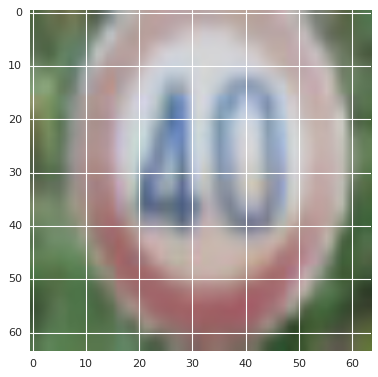

In [13]:
from PIL import Image
im = Image.open("./test_dataset/limitspeed-00087.jpg", "r")
plt.imshow(np.array(im))
img = np.frombuffer(np.array(Image.open('./test_dataset/limitspeed-00087.jpg').convert('RGB')),dtype=np.uint8)
img = img.astype(np.float32)
img /= 255.0
predict_img = np.array([img])
ans = np.argmax(sess.run(y_conv,feed_dict={X:predict_img,keep_prob:1.0}))
if(ans == 0):
  print('Mark is stop')
elif(ans == 1):
  print('Mark is limitspeed')